## Question 1: Is there a relationship between quarterback fantasy points scored and team defense fantasy points scored on the same team?
In other words, does a quarterback who scores more fantasy points (and presumably more real NFL points for his team) have any effect on how their team's defense performs?
- **What is your hypothesis?**: I hypothesize that quarterback fantasy football scoring will have no effect on team defense fantasy point scoring. The quarterback plays on the offensive side of the ball, and so how the QB performs should not statistically influence how his defense performs, since they are not on the football field at the same time (teams take turns switching off playing offense/defense)
- **How does this relate to the researcher's question?**: This question is related to the researcher's question because they were trying to use a model to predict the number of fantasy points a quarterback/team defense might score. If quarterback fantasy point scoring was a strong predictor of team defensive scoring (or vice versa), the researchers could've added this to their model.
- **How does this relate to Part 1?**: This question is a more specific form of the research question I asked in part 1. I'm examining this question for quarterbacks/team defenses from the same team.
- **Why use this data?**: This data provides information about the team QBs/DSTs belonged to, as well as how many fantasy points they scored for each week of the NFL season.
- **Which features will you be using?**: I will be using `fantasy points scored`, `team`, and `player` to complete this assignment
- **How many observations are there for each feature?**: There are the same number of observations for each feature, which is 15 * the number of players at that position.
    - For QBs: 585
    - For DSTs: 480
    - Since the reason there are more quarterbacks is because some teams played multiple quarterbacks, I will simplify this analysis by combining the QBs that played for an individual team and treating them as if they were 1 QB

In [2]:
# Code from earlier sections to import and clean the dataset

# import packages and dataset
import pandas as pd

# These were imported for each fantasy football position type (QB or DST)
QB = pd.read_excel('../Data/Accuscore Evaluation.xlsx', sheet_name='QB Projections')
DST = pd.read_excel('../Data/Accuscore Evaluation.xlsx', sheet_name= 'DST Projections')

# Remove duplicate columns (PLAYERID/ESPNID is simply an alias for PLAYER)
QB = QB.drop(['PLAYERID', 1], axis=1)
# Since defenses are played per team, as long as we have the TEAM data, we know what the name of the player is
DST = DST.drop(['ESPNID', 'PLAYER'], axis=1)
# Rename ORDER column to WEEK for clarity (since order describes the week of the NFL season)
QB = QB.rename(columns={'ORDER':'WEEK'})
DST = DST.rename(columns={'ORDER':'WEEK'})


# Remove Ben Roethelisberger's and Andrew Luck's bye weeks (Week 4), since the authors forgot to
ben_bye = ((QB['WEEK'] == 4) & (QB['PLAYER'] == 'Ben Roethlisberger')).astype(int).idxmax()
luck_bye = ((QB['WEEK'] == 4) & (QB['PLAYER'] == 'Andrew Luck')).astype(int).idxmax()
QB = QB.drop([ben_bye, luck_bye], axis=0)

In [7]:
# Get a list of all of the NFL teams as a set
teams = set(QB['TEAM'])
# Get a list of the weeks of the NFL season as a set (we'll need these to figure out how many points the QBs for a team scored in a given week)
weeks = set(QB['WEEK'])
display(teams, weeks)

{'ARI',
 'ATL',
 'BAL',
 'BUF',
 'CAR',
 'CHI',
 'CIN',
 'CLE',
 'DAL',
 'DEN',
 'DET',
 'GB',
 'HOU',
 'IND',
 'JAC',
 'KC',
 'MIA',
 'MIN',
 'NE',
 'NO',
 'NYG',
 'NYJ',
 'OAK',
 'PHI',
 'PIT',
 'SD',
 'SEA',
 'SF',
 'STL',
 'TB',
 'TEN',
 'WAS'}

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

In [22]:
# Additional cleaning to be able to make this plot
import seaborn as sns
# Create a df where rows will be team-week pairs, and columns will be QB and DST scoring
team_scoring_df = pd.DataFrame()
# For each NFL team
for team in teams:
    # For each week of the NFL season from 1-16
    for week in weeks:
        # Figure out how many fantasy points that team's quarterback(s) scored that week, and add it to the df with the row as a team-week pair, and the column as 'QB Scoring'
        team_scoring_df.loc[team + '-' + str(week), 'QB Scoring'] = QB.loc[(QB['WEEK'] == week) & (QB['TEAM'] == team), 'Actuals'].sum()
        # Add however many points the team's defense unit scored to the df, and add it to the df with the row as a team-week pair, and the column as 'DST Scoring'
        team_scoring_df.loc[team + '-' + str(week), 'DST Scoring'] = DST.loc[(DST['WEEK'] == week) & (DST['TEAM'] == team), 'Actuals'].sum()

## Rationale for plot
- **What type of plot are you making?**: I am making a regression (reg) plot, which consists of a scatterplot and a regression line
- **Why will this plot give you insight?**: I'm trying to model a potential linear relationship between QB fantasy points scored and DST fantasy points scored.
    - This visualization is purpose-built for visualizing potential linear relationships
- **What do you expect to see?**: Since I expected there to be no relationship, I would expect to see random scatter with a nearly horizontal trendline of QB fantasy point scoring vs. DST fantasy point scoring.
- **How will the result inform your hypothesis?**: If the scatter of the plot does not look like it follows a pattern, and the regression line looks horizontal, there will not be enough evidence to reject my hypothesis. Otherwise, I will have to reject my hypothesis and conclude that there is a linear relationship between QB scoring and DST scoring for the same team.

<AxesSubplot:xlabel='QB Scoring', ylabel='DST Scoring'>

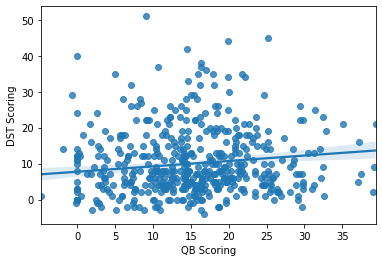

In [23]:
# Plot
sns.regplot(data=team_scoring_df, x='QB Scoring', y='DST Scoring')

### Plot interpretation
- I can conclude that there is not a significant linear relationship between QB fantasy point scoring and DST fantasy point scoring on the same team. QB scoring would not be a good predictor of DST scoring, and vice versa

### Model explanation
- **What feature(s) are you modeling and why is this model appropriate for that?**: I am modeling a linear relationship between QB fantasy point scoring and DST fantasy point scoring separated by teams. Points will be a (QB fpoints scored, DST fpoints scored) XY pair. A linear model is appropriate as a way to determine whether a significant relationship exists between these two variables because it is easily statistically testable.
- **What other feature(s) are used in the model, if any, and why are they included?**: I will be using team and week in this model to separate the points from one another.
- **How will this model inform your hypothesis?**: If the model is significant (p > 0.05), I will reject my hypothesis that there is no relationship between QB and DST scoring
- **What kind of parameters do you expect for your model, based on your visualization?**: I expect a slope, an intercept, and a p-value associated with the intercept.

In [25]:
# Model
import statsmodels.api as sm
# Add a constant to the data (need mx + b, not just mx)
to_model = sm.add_constant(team_scoring_df)
# Create input data (X), which is the constant and QB scoring
X = to_model.loc[:, ['const', 'QB Scoring']]
# Create output data (y), which is the DST scoring
y = to_model['DST Scoring']
# Fit a linear model to the DST vs QB data
model = sm.OLS(y,X).fit()
# Print out a summary of the statistics of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            DST Scoring   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     10.38
Date:                Sun, 20 Nov 2022   Prob (F-statistic):            0.00136
Time:                        21:24:00   Log-Likelihood:                -1861.5
No. Observations:                 512   AIC:                             3727.
Df Residuals:                     510   BIC:                             3735.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7443      0.779      9.944      0.000       6.214       9.274
QB Scoring     0.1498      0.046      3.222      0.001       0.058       0.241
==============================================================================
Omnibus:                      110.619   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.954
Skew:                           1.260   Prob(JB):                     1.71e-43
Kurtosis:                       4.696   Cond. No.                         32.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model interpretation
- **What can we conclude about the parameters of the model?**: DST fantasy point scoring is positively correlated to QB fantasy point scoring. For every 1 fantasy point the QB scores, a defense can be expected to score ~0.15 fantasy points
- **How certain/uncertain are we about them?**: Based on the probability from the t-test (P > |t|), we are 99.9% confident that there is a significant, linear relationship between DST scoring and QB scoring.
- **What conclusions can we make about the research question based on the model results?**: QB scoring is predictive of DST scoring, and should be added to the authors' model to help improve their projections. One way this could be done is by keeping track of how many points a quarterback scores, on average, and using this linear model to add a flat amount of points to the DST projection for his team.


## Question 2: Do more top-8 quarterback weekly finishes result in a higher average fantasy points scored?
- **What is your hypothesis?**: I hypothesize that there will be a linear relationship, but it will not be very strong
- **How does this relate to the researcher's question?**: This question is more relevant for fantasy football managers, because in a typical 12-team fantasy league there are only 12 quarterbacks in fantasy starting lineups each week. Knowing that a wide (or narrow) % of QBs will finish with at least one top-8 week (a fantasy-relevant week) allows players to make informed decisions about how to value the QB position (is it replaceable? will lots of quarterbacks score well at least once? Then it should be valued below more scarce positions. Otherwise, it should be highly valued.)
- **How does this relate to Part 1?**: This is asking a similar style of question, where the goal is to gain insight into what factors produce consistent, high-scoring fantasy football players
- **Why use this data?**: This data provides information about the how many fantasy points QBs scored every week
- **Which features will you be using?**: I will be using `fantasy points scored` and `player` to answer this question
- **How many observations are there for each feature?**: There are the same number of observations for each feature, which is 15 * the number of players at the QB position (585)

In [71]:
# Code from earlier sections to import and clean the dataset

# import packages and dataset
import pandas as pd

# These were imported for each fantasy football position type (QB or DST)
QB = pd.read_excel('../Data/Accuscore Evaluation.xlsx', sheet_name='QB Projections')

# Remove duplicate columns (PLAYERID/ESPNID is simply an alias for PLAYER)
QB = QB.drop(['PLAYERID', 1], axis=1)
# Rename ORDER column to WEEK for clarity (since order describes the week of the NFL season)
QB = QB.rename(columns={'ORDER':'WEEK'})


# Remove Ben Roethelisberger's and Andrew Luck's bye weeks (Week 4), since the authors forgot to
ben_bye = ((QB['WEEK'] == 4) & (QB['PLAYER'] == 'Ben Roethlisberger')).astype(int).idxmax()
luck_bye = ((QB['WEEK'] == 4) & (QB['PLAYER'] == 'Andrew Luck')).astype(int).idxmax()
QB = QB.drop([ben_bye, luck_bye], axis=0)

In [74]:
# Additional cleaning to be able to make this plot
import seaborn as sns
# Create a df where rows will be players, and columns will be number of weeks in the top 8
qb_scoring_df = pd.DataFrame()
# For each week of the NFL season
for week in weeks:
    # Sort QBs for the week by how many fantasy points they scored (high to low), and take the top 8
    top8 = QB[QB['WEEK'] == week].sort_values('Actuals', ascending=False)[0:7]
    # for each player
    for player in top8['PLAYER']:
        # If they've already had a top 8 week
        if player in qb_scoring_df.index:
            # Add 1 to their total
            qb_scoring_df.loc[player, 'Occurences'] += 1
        else:
            # This is their first week in the top 8
            qb_scoring_df.loc[player, 'Occurences'] = 1

print('QBs with at least 1 top 8 week:', qb_scoring_df.shape[0])

# Add everyone without a week in the top 8 to the df (for visualization purposes)
for player in set(QB['PLAYER']):
    if player in qb_scoring_df.index:
        # Do nothing, they already made it in
        pass
    else:
        # This is their first week in the top 8
        qb_scoring_df.loc[player, 'Occurences'] = 0

# Add mean fpts scored for each player
qb_scoring_df = qb_scoring_df.sort_index(axis=0)
qb_scoring_df['Average'] = QB.groupby('PLAYER')['Actuals'].mean()

QBs with at least 1 top 8 week: 30


## Rationale for plot
- **What type of plot are you making?**: I am making 2 histograms
- **Why will this plot give you insight?**: I'm trying to visualize the distribution of how many top 8 weeks a quarterback can be expected to have, on average
- **What do you expect to see?**: I expect to see most quarterbacks between 0 and 2 occurences, with fewer and fewer quarterbacks as the number of weeks in the top 8 increases
- **How will the result inform your hypothesis?**: I will see if QB scoring follows the distribution I would expect, and whether average fpts scored follows a similar distribution

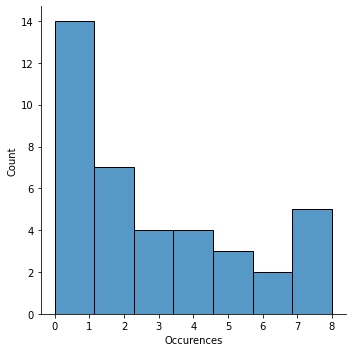

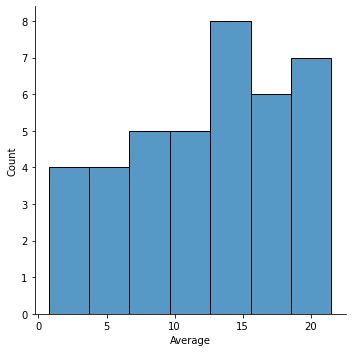

In [75]:
# Plot
sns.displot(data=qb_scoring_df, x='Occurences')
sns.displot(data=qb_scoring_df, x='Average')

### Plot interpretation
- The majority of quarterbacks (over 20) have 1 or fewer weeks in the top-8 quarterbacks. Of the remaining 19 NFL quarterbacks, there seems to be an even distribution of weeks in the top 8
- Fantasy point average does not follow a similar distribution to top-8 QB weeks

### Model explanation
- **What feature(s) are you modeling and why is this model appropriate for that?**: I am modeling average fantasy points scored and weeks in the top 8 quarterbacks using a linear model. This model will test if there is a relationship between average fantasy points scored and weeks in the top 8 quarterbacks. Intuitively, these two should have a relationship, but there may be quarterbacks who score in the top-12 or top-15 on a weekly basis, and finish the season in the top-10 (as a fantasy-relevant QB) by sheer volume/stat accumulation because of their consistency.
- **What other feature(s) are used in the model, if any, and why are they included?**: Average fantasy points scored for each player
- **How will this model inform your hypothesis?**: This model will add some context to my hypothesis. Does having less top-8 finishes necessarily mean a player is a "worse" fantasy QB?
- **What kind of parameters do you expect for your model, based on your visualization?**: I expect a slope, an intercept, and a p-value associated with the intercept.

In [76]:
# Model
import statsmodels.api as sm

# Add a constant to the data (need mx + b, not just mx)
to_model = sm.add_constant(qb_scoring_df)
# Create input data (X), which is the constant and QB scoring
X = to_model.loc[:, ['const', 'Occurences']]
# Create output data (y), which is the DST scoring
y = to_model['Average']
# Fit a linear model to the DST vs QB data
model = sm.OLS(y,X).fit()
# Print out a summary of the statistics of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Average   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     142.4
Date:                Sun, 20 Nov 2022   Prob (F-statistic):           3.02e-14
Time:                        23:32:22   Log-Likelihood:                -93.941
No. Observations:                  39   AIC:                             191.9
Df Residuals:                      37   BIC:                             195.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5008      0.670      9.701      0.000       5.143       7.859
Occurences     2.0916      0.175     11.932      0.000       1.736       2.447
==============================================================================
Omnibus:                        0.384   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.825   Jarque-Bera (JB):                0.537
Skew:                          -0.004   Prob(JB):                        0.765
Kurtosis:                       2.425   Cond. No.                         6.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model interpretation
- **What can we conclude about the parameters of the model?**: Number of top-8 weeks is predictive of fantasy point average for QBs. For each top-8 week, the QB's average points scored increases by 2 points
- **How certain/uncertain are we about them?**: Based on the probability from the t-test (P > |t|), we are nearly 100% confident that there is a significant, linear relationship between top-8 scoring weeks and QB scoring.
- **What conclusions can we make about the research question based on the model results?**: QBs with more top-8 weeks tend to have a higher average scoring. If a QB scores highly in 1 or 2 weeks, it's more likely that he will continue to score highly.
